 **1. Original Trial Design**
-----------------------------------------------------
**A. Detector Setup:**
   - **2 Layers of Cylindral Shell Detectors**, 
     - **Inner, silicon** 
     - **Outer, scintillator**  
     

**B. Particle Generation:**
   - **Types:** Electrons & Photons, 50% for each
   - **Energy Range:** 200 MeV - 20 GeV
   - **Initial Direction:** +x
   - **Each event records:**
     - Position (**X, Y, Z**)
     - Momentum (**MomX, MomY, MomZ**)
     - Energy
     - Particle Type and Fired Energy (Truth Label)

**C. Output Data:**
   - **Detector CSV Files** (logs hits for each layer)
   - **Truth CSV File** (stores original particle properties)

There are 2000 events in all.

In [1]:
import pandas as pd
import os
import numpy as np

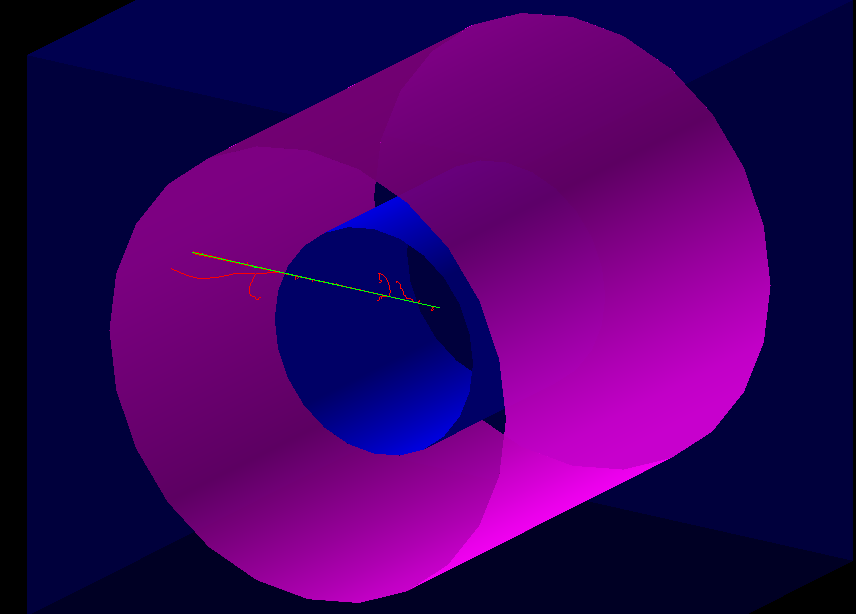

In [2]:
from IPython.display import Image, display
display(Image(filename="Screenshot from 2025-03-13 22-51-26.png"))

### 1.1 Data reading and preprocessing

In [3]:
def read_truth_csv(filepath):

    df = pd.read_csv(filepath, comment='#', header=None)
    df.columns = ["EventNumber", "Energy", "X", "Y", "Z", "Px", "Py", "Pz", "ParticleType"]
    return df

def read_detector_csv(filepath):

    df = pd.read_csv(filepath, comment='#', header=None)
    df.columns = ["EventNumber", "Energy", "X", "Y", "Z", "Px", "Py", "Pz"]
    return df

data_dir = "data" # original data folder for simple detector
truth_file = os.path.join(data_dir, "output_nt_Truth.csv")

df_truth = read_truth_csv(truth_file)
print("Truth data loaded:", df_truth.shape)
df_truth.head()

Truth data loaded: (2000, 9)


,EventNumber,Energy,X,Y,Z,Px,Py,Pz,ParticleType
0,0,15126.00,0,0,15126.00,22,0,0,0
1,1,15172.00,0,0,15172.00,22,0,0,0
2,2,13097.30,0,0,13097.30,11,0,0,0
3,3,1020.38,0,0,1020.38,11,0,0,0
4,4,17658.00,0,0,17658.00,22,0,0,0


We are only selecting the most energetic event.

In [4]:
def select_top_hit_per_event(df, layer_name):
    """
    Groups by EventNumber, picks the row with the highest energy per event.
    Renames the columns to incorporate the layer name.
    """
    # For each event, find the index with max 'Energy'
    idx_max = df.groupby("EventNumber")["Energy"].idxmax()
    df_top = df.loc[idx_max].copy()
    
    # enclosing the layer name in the title
    rename_map = {}
    for col in ["Energy", "X", "Y", "Z", "Px", "Py", "Pz"]:
        rename_map[col] = f"{layer_name}_{col}"
    
    df_top.rename(columns=rename_map, inplace=True)
    return df_top[["EventNumber"] + list(rename_map.values())]

# 2 layers
layer_files = {
    "L1": os.path.join(data_dir, "output_nt_Tracker1.csv"),
    "L2": os.path.join(data_dir, "output_nt_Tracker2.csv"),
}

layer_dfs = []
for layer_name, path in layer_files.items():
    df_layer = read_detector_csv(path)
    df_top = select_top_hit_per_event(df_layer, layer_name)
    layer_dfs.append(df_top)

In [5]:
df_merged = df_truth.copy()
for df_layer in layer_dfs:
    df_merged = pd.merge(df_merged, df_layer, on="EventNumber", how="left")

# NaN → fill with 0
for col in df_merged.columns:
    if "_" in col:  # columns from layers
        df_merged[col].fillna(0, inplace=True)

print("Merged shape:", df_merged.shape)
df_merged.head()

Merged shape: (2000, 23)


C:\Users\王逸非\AppData\Local\Temp\ipykernel_18148\2282869933.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged[col].fillna(0, inplace=True)


,EventNumber,Energy,X,Y,Z,Px,Py,Pz,ParticleType,L1_Energy,...,L1_Px,L1_Py,L1_Pz,L2_Energy,L2_X,L2_Y,L2_Z,L2_Px,L2_Py,L2_Pz
0,0,15126.00,0,0,15126.00,22,0,0,0,0.00,...,0.00,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000,0.00000,0.00000
1,1,15172.00,0,0,15172.00,22,0,0,0,0.00,...,0.00,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000,0.00000,0.00000
2,2,13097.30,0,0,13097.30,11,0,0,0,12917.00,...,12917.00,0.565781,2.84188,12914.00,8000.00,0.910610,1999.52,12914.000,3.69422,6.53247
3,3,1020.38,0,0,1020.38,11,0,0,0,1015.23,...,1015.22,2.426900,-2.43310,948.01,8000.00,0.862436,1988.95,947.998,2.36446,-4.26680
4,4,17658.00,0,0,17658.00,22,0,0,0,9435.75,...,9435.75,0.339634,2.60958,9347.56,7996.44,1.236040,2001.64,9347.560,3.50500,3.95504


In [6]:
df_filtered = df_merged

df_filtered.reset_index(drop=True, inplace=True)

feature_cols = []
for layer_name in sorted(layer_files.keys()):
    for feat in ["Energy", "X", "Y", "Z", "Px", "Py", "Pz"]:
        feature_cols.append(f"{layer_name}_{feat}")

metadata_path_old = "meta_dataframe_old.csv"
df_filtered.to_csv(metadata_path_old, index=False)

Do one-hot encoding to y

In [7]:
X = df_filtered[feature_cols].values
y_raw = df_filtered["ParticleType"].values

In [8]:
def turn_onehot(y_binary):
    y_onehot = np.zeros((len(y_binary), 2))
    # y_binary: 0 → [1,0], 1 → [0,1]
    for i, label in enumerate(y_binary):
        if label == 11:  
            y_onehot[i] = [1, 0]
        else:           
            y_onehot[i] = [0, 1]

    return y_onehot

y_onehot = turn_onehot(y_raw)

print("One-hot shape:", y_onehot.shape)  # Nx2

One-hot shape: (2000, 2)


### 1.2 Train a Basic Model

The feture we're using here is the x,y,z position, x,y,z momentum and energy detected by each layer, and the label is the particle type we fired for each EventID.\
Although this seems to be unphysical because we can't know the particle type before a unknown event, but we still can fire a bunch of known particles and let the model learn it deliberately, so that after it is trained, it is able to process unseen events and tell the particle types. A more robust model can be created by training it with more data from more types of particles (also adding new labels to be classified).\
For energy reconstruction, we are using a traditional way that we simply use the energy detected by the first layer, as the design of this simple structure is bound to let high-E particles through. It is also not a good idea to keep track of all deposited energy and summing them up for E-reconstruction. This is because you can potentially never collect all deposited energy accurately for very high E particles.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
def basic_model(input_shape, output_shape):
    model = keras.Sequential([
        layers.Dense(32, activation="relu", input_shape=(input_shape,)),
        layers.Dropout(0.2),  # Prevents overfitting
        
        layers.Dense(16, activation="relu"),

        
        layers.Dense(2, activation="relu"),

        
        layers.Dense(output_shape, activation="softmax")
    ])
    
    # Compile model with Adam optimizer and learning rate scheduling
    model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=[
                  "accuracy", 
                  "precision", 
                  "recall",
                  "AUC"
                ])
    return model

In [12]:
# Hyperparameters
N_epochs = 300
batchSize = 64

# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, min_delta=0.003)

# Learning rate scheduler (reduces LR if no improvement)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# Set up n-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
history_list = []  # Store training history

all_preds_per_epoch = []
all_true_per_epoch = []

# Perform n-fold cross-validation with full evaluation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_scaled), 1):
    print(f"Training Fold {fold}...")

    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_onehot[train_idx], y_onehot[val_idx]

    # Create and train the model
    model = basic_model(X_train.shape[1], y_train.shape[1])
    history = model.fit(X_train, y_train, epochs=N_epochs, batch_size=batchSize, verbose=1,
              validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])

    history_list.append(history.history)


    # Track predictions for debugging
    y_pred = model.predict(X_val)  # Get predicted probabilities
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert softmax to class labels
    y_true_labels = np.argmax(y_val, axis=1)  # Convert one-hot encoded true labels

    # Store predictions and true labels per epoch
    all_preds_per_epoch.append(y_pred_labels)
    all_true_per_epoch.append(y_true_labels)

Training Fold 1...
Epoch 1/300


d:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - AUC: 0.4351 - accuracy: 0.6078 - loss: 0.7457 - precision: 0.6319 - recall: 0.6078 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.6450 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9946 - accuracy: 0.9949 - loss: 0.6233 - precision: 0.9949 - recall: 0.9949 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5414 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.4978 - precision: 1.0000 - recall: 1.0000 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.3583 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.3114 - precision: 1.0000 - recall: 1.0000 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.1778 - val_precision: 1.0

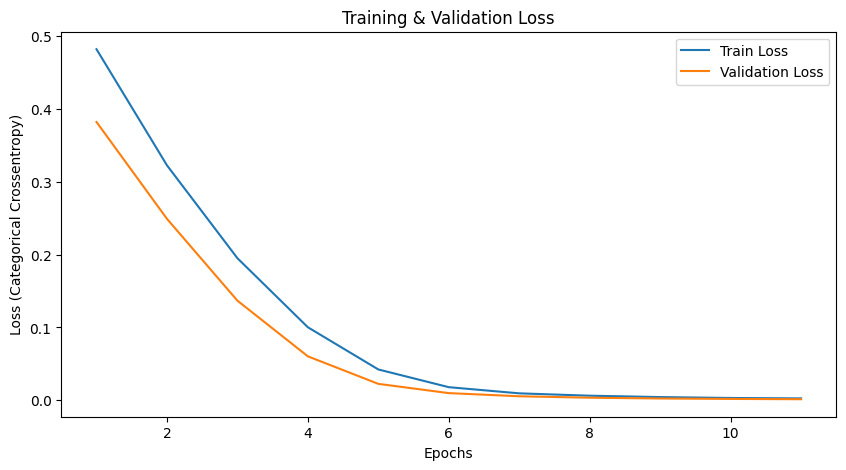

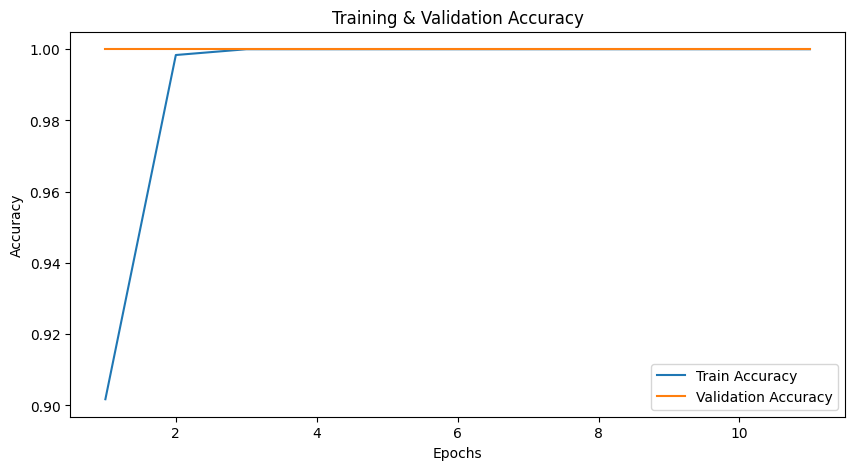

In [13]:
# Find the shortest training history (due to early stopping)
min_epochs = min(len(h["loss"]) for h in history_list)

# Trim all histories to the minimum epoch length
train_loss = np.mean([h["loss"][:min_epochs] for h in history_list], axis=0)
val_loss = np.mean([h["val_loss"][:min_epochs] for h in history_list], axis=0)

train_acc = np.mean([h["accuracy"][:min_epochs] for h in history_list], axis=0)
val_acc = np.mean([h["val_accuracy"][:min_epochs] for h in history_list], axis=0)

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, min_epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, min_epochs + 1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (Categorical Crossentropy)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, min_epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, min_epochs + 1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()

In [14]:
# Compute mean and standard deviation for validation metrics
val_accuracy_mean = np.mean([h["val_accuracy"][-1] for h in history_list])
val_accuracy_std = np.std([h["val_accuracy"][-1] for h in history_list])

val_precision_mean = np.mean([h["val_precision"][-1] for h in history_list]) if "val_precision" in history_list[0] else None
val_precision_std = np.std([h["val_precision"][-1] for h in history_list]) if "val_precision" in history_list[0] else None

val_recall_mean = np.mean([h["val_recall"][-1] for h in history_list]) if "val_recall" in history_list[0] else None
val_recall_std = np.std([h["val_recall"][-1] for h in history_list]) if "val_recall" in history_list[0] else None

val_f1_mean = np.mean([h["val_AUC"][-1] for h in history_list]) if "val_AUC" in history_list[0] else None
val_f1_std = np.std([h["val_AUC"][-1] for h in history_list]) if "val_AUC" in history_list[0] else None

# Print final results with standard deviations
print("\nFinal 3-Fold Cross-Validation Performance (from Training History):")
print(f"Validation Accuracy:  {val_accuracy_mean:.4f} ± {val_accuracy_std:.4f}")
if val_precision_mean is not None:
    print(f"Validation Precision: {val_precision_mean:.4f} ± {val_precision_std:.4f}")
if val_recall_mean is not None:
    print(f"Validation Recall:    {val_recall_mean:.4f} ± {val_recall_std:.4f}")
if val_f1_mean is not None:
    print(f"Validation AUC Score:  {val_f1_mean:.4f} ± {val_f1_std:.4f}")


Final 3-Fold Cross-Validation Performance (from Training History):
Validation Accuracy:  1.0000 ± 0.0000
Validation Precision: 1.0000 ± 0.0000
Validation Recall:    1.0000 ± 0.0000
Validation AUC Score:  1.0000 ± 0.0000


### 1.3 Simple Energy Reconstruction

In [15]:
def compute_resolution_efficiency(df, layer_prefixes, truth_energy_col="Energy"):
    """
    For each event, use the energy in first layer, compare with the truth energy,
    and compute:
      - Resolution = (MeasuredEnergy - TruthEnergy) / TruthEnergy
      - Efficiency ratio = MeasuredEnergy / TruthEnergy
    """
    # Sum energies from each layer (assumes each layer column is named like "L1_Energy", "L2_Energy", etc.)
    measured_energy_cols = [f"{layer}_Energy" for layer in layer_prefixes]
    df["MeasuredEnergy"] = df[measured_energy_cols].mean(axis=1)
    
    # Compute resolution: (MeasuredEnergy - TruthEnergy) / TruthEnergy
    df["Resolution"] = (df["MeasuredEnergy"] - df[truth_energy_col]) / df[truth_energy_col]
    
    # Compute efficiency ratio: MeasuredEnergy / TruthEnergy
    df["Efficiency"] = df["MeasuredEnergy"] / df[truth_energy_col]
    
    # Print summary statistics
    print("Mean Resolution:", df["Resolution"].mean())
    print("Std Resolution:", df["Resolution"].std())
    print("Mean Efficiency:", df["Efficiency"].mean())
    print("Std Efficiency:", df["Efficiency"].std())
    
    # Plot histograms for resolution and efficiency
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,5))
    

    plt.figure(figsize=(18,5))

    plt.subplot(1,3,1)
    plt.scatter(df[truth_energy_col], df["MeasuredEnergy"] , alpha=0.5)
    plt.plot([df[truth_energy_col].min(), df[truth_energy_col].max()], [df[truth_energy_col].min(), df[truth_energy_col].max()], 'r--')
    plt.xlabel("Truth Energy")
    plt.ylabel("Reconstructed Energy")
    plt.title("Reconstructed vs Truth Energy")

    plt.subplot(1,3,2)
    plt.hist(df["Resolution"], bins=50, color='skyblue', edgecolor='black')
    plt.title('Resolution Distribution')
    plt.xlabel('(Predicted - Truth)/Truth')

    plt.subplot(1,3,3)
    plt.hist(df["Efficiency"], bins=50, color='salmon', edgecolor='black')
    plt.title('Efficiency Distribution')
    plt.xlabel('Predicted / Truth')

    plt.tight_layout()
    plt.show()
        
    # Return a DataFrame with the calculated values
    return df[["EventNumber", "MeasuredEnergy", truth_energy_col, "Resolution", "Efficiency"]]

Mean Resolution: -0.47023984459155643
Std Resolution: 0.6073693090796244
Mean Efficiency: 0.5297601554084436
Std Efficiency: 0.6073693090796244


<Figure size 1200x500 with 0 Axes>

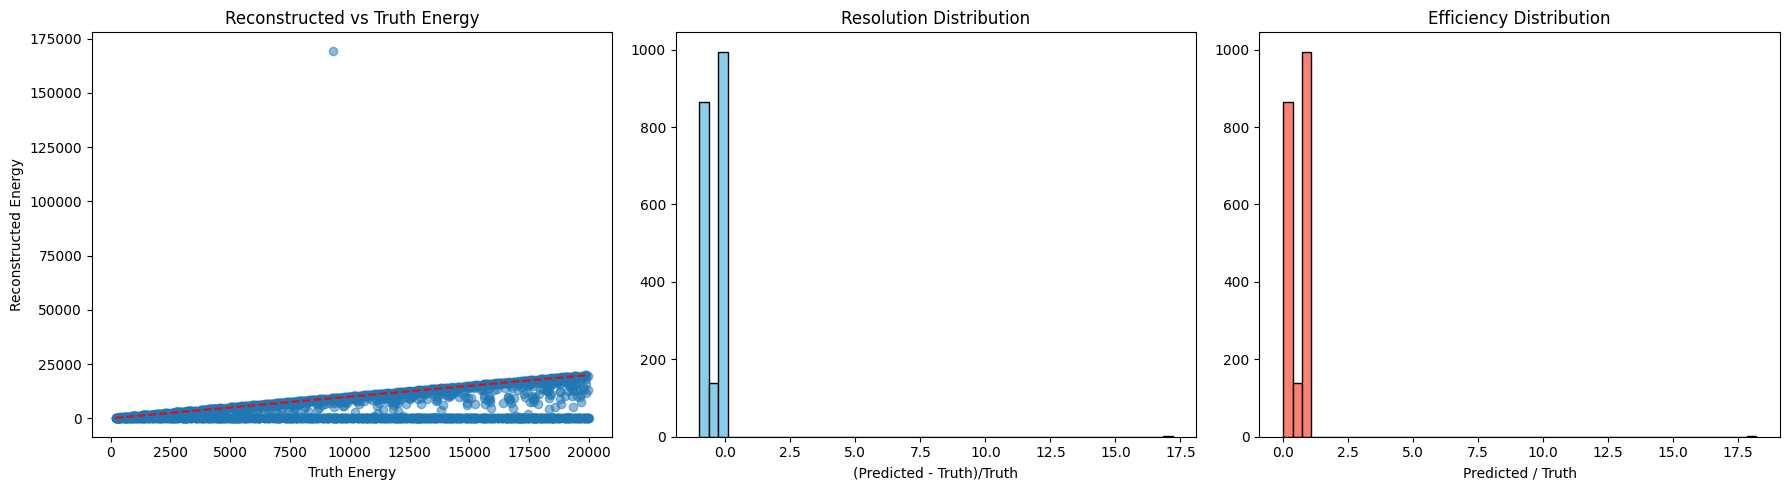

   EventNumber  MeasuredEnergy    Energy  Resolution  Efficiency
0            0            0.00  15126.00   -1.000000    0.000000
1            1            0.00  15172.00   -1.000000    0.000000
2            2        12917.00  13097.30   -0.013766    0.986234
3            3         1015.23   1020.38   -0.005047    0.994953
4            4         9435.75  17658.00   -0.465639    0.534361


In [16]:
layer_prefixes = sorted(["L1"])
df_results = compute_resolution_efficiency(df_merged, layer_prefixes, truth_energy_col="Energy")
print(df_results.head())

comment: The model seemed to be working very well, 100% correct, in distinguishing the electrons from the photons. \
This is reasonable as the detector is simple in structure, and the incoming two particles will interact with this kind of simple structures very differently. \
Also, this simple structure has a big problem: it has a very limited range of energy detection. \
Because there are only two very thin layers, they are very likely to let energetic particles through, and they leave less information on the detector if they can't interact with the very thin layers well enough. The reconstruction of energy is not ideal, as the resolution is almost around 0.01, and have a huge std of around 0.1. From the left most plot above, the blue dots are clearly not ideal (not randomly distributed around the red line) and biased, especially when the energies go very large. There's also a clear distinction between the two types of particles in the reconstructed energy, as there's a bunch of blue dots horizontally lined up in the bottom. This is because one type of the particle doesn't interact with the layers at all.

Next, I will try a more complex detector strucure, and of course, much more data to analysis. So the simple basic NN model should also be updated. Let's see.

**2. Updated Geant4 Design**
-----------------------------------------------------

**A. Detector Setup:**
   - **3 Groups of Hemisphere Detector Layers**, each containing:
     - **Liquid Argon (green)**  (momentum absorption to capture a wider energy range; optional scintillation light for timing/energy info)
     - **Pyrex Glass (white)**  (filters low-energy particles, potentially generates Cherenkov photons for velocity discrimination for super high E particles)
     - **Plastic Scintillator (yellow)**  (electron detection via scintillation)
   - **Enclosure (red, less opaque):**  Tungsten surrounding all layers as a final warp-up detector for full energy containment and high-energy tails.

**B. Particle Generation:**
   - **Types:** Electrons & Photons, 50% for each (binary classification problem; expandable to more particles in the future).
   - **Energy Range:** 200 MeV - 20 GeV.
   - **Initial Direction:** +z.
   - **Each event records:**
     - Position (**X, Y, Z**)
     - Momentum (**MomX, MomY, MomZ**)
     - Energy
     - Particle Type (Truth Label)
     - Event ID (for linking hits to true label)

**C. Output Data:**
   - **Detector CSV Files** (logs hits for each layer, one row per hit, containing):
     - `EventID` (unique per event)
     - `LayerID` (layer name or ID: Argon, Pyrex, Scintillator, Tungsten)
     - `HitX, HitY, HitZ` (3D hit position)
     - `MomentumX, MomentumY, MomentumZ` (3D Momentum)
     - `Energy`

   - **Truth CSV File** (stores original particle properties for supervised training):
     - `EventID` (to link with detector hits)
     - `TrueParticleType` (electron or photon)
     - `TrueEnergy` (initial total energy)
     - `TrueMomentumX, TrueMomentumY, TrueMomentumZ` (initial momentum)


By adding more layers and liquid Argon detectors for energy absorption, it is possible to have a more detailed research into a wider range of energy.

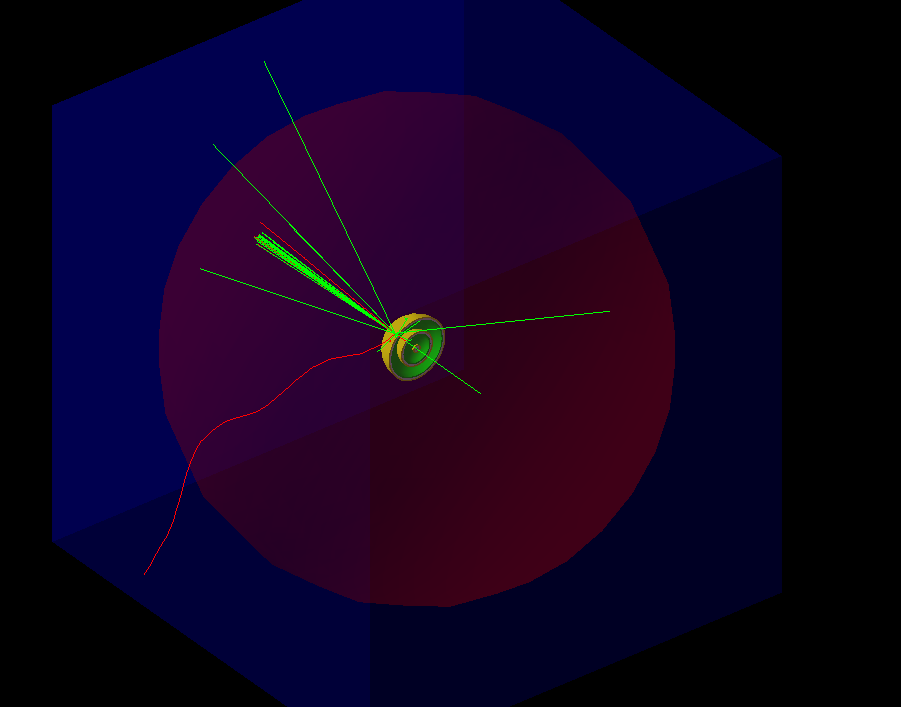

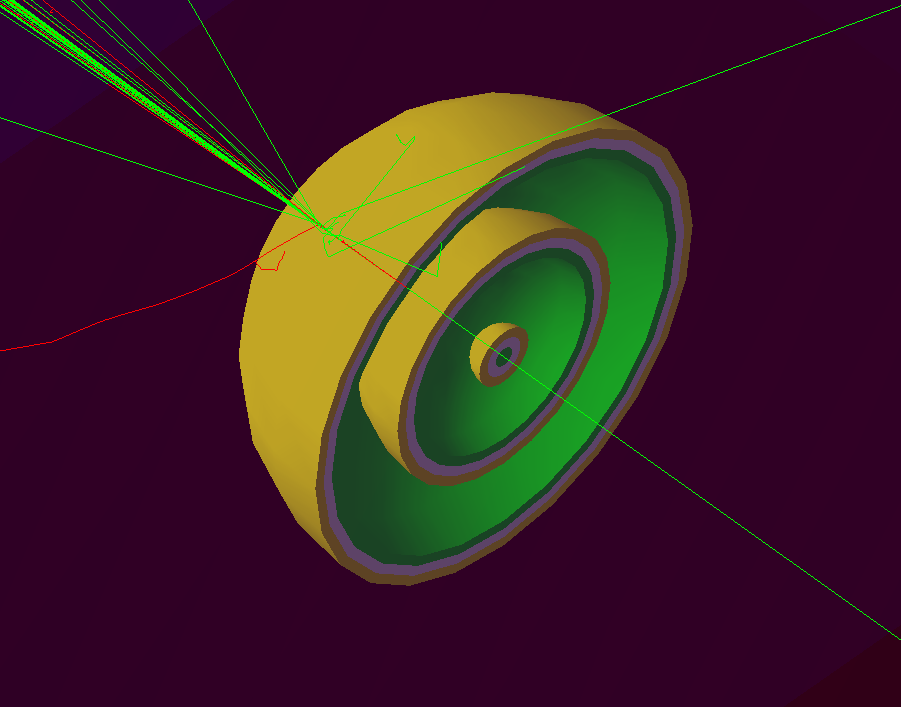

In [17]:
from IPython.display import Image, display
display(Image(filename="Screenshot from 2025-03-13 19-20-21.png"))
display(Image(filename="Screenshot from 2025-03-13 19-21-05.png"))

### 2.1. Data Extraction of the Updated Detector

similar process to create metadata from csv files

In [18]:
import pandas as pd
import glob
import os

In [ ]:
# Define directory path
data_dir = "data_new" 

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

data_dict = {}

# Read Truth Data
truth_file = os.path.join(data_dir, "output_nt_Truth.csv")
truthData = pd.read_csv(truth_file, comment="#", names=["EventID", "mx", "my", "mz", "E", "Type"])
true_particles = truthData.groupby('EventID').size()

In [20]:
# Read Detector Data
layer_data = {}
for file in csv_files:
    if "Truth" not in file:  # Skip truth file
        layer_name = os.path.basename(file).replace(".csv", "")
        trackerData = pd.read_csv(file, comment="#", names=["EventID", "x", "y", "z", "mx", "my", "mz", "E"])
        layer_data[layer_name] = trackerData

Now using the 3 most energetic particles here.

In [21]:
# Function to take the 3 highest energy particles and compute their average parameters
def top3_average(df):
    top3 = df.nlargest(3, "E")  # Select the top 3 highest energy particles
    return pd.Series({
        "Avg_mx": top3["mx"].mean(),
        "Avg_my": top3["my"].mean(),
        "Avg_mz": top3["mz"].mean(),
        "Avg_E": top3["E"].mean(),
        "Avg_x": top3["x"].mean() if "x" in df else None,
        "Avg_y": top3["y"].mean() if "y" in df else None,
        "Avg_z": top3["z"].mean() if "z" in df else None
    })

In [22]:
# Process each detector layer and compute the top 3 energy averages per event
layer_averages = {}
for layer, df in layer_data.items():
    layer_averages[layer] = df.groupby("EventID").apply(top3_average)
# Merge all layer averages into a single DataFrame
meta_dataframe = pd.concat(layer_averages, axis=1)

C:\Users\王逸非\AppData\Local\Temp\ipykernel_18148\1949156685.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  layer_averages[layer] = df.groupby("EventID").apply(top3_average)
C:\Users\王逸非\AppData\Local\Temp\ipykernel_18148\1949156685.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  layer_averages[layer] = df.groupby("EventID").apply(top3_average)
C:\Users\王逸非\AppData\Local\Temp\ipykernel_18148\19491566

In [23]:
meta_dataframe = meta_dataframe.fillna(0)

This is to re-format the dataframe into single-indexed

In [24]:
# Check if meta_dataframe has a MultiIndex
if isinstance(meta_dataframe.columns, pd.MultiIndex):
    # Flatten multi-level columns
    meta_dataframe.columns = ["{}_{}".format("".join(map(str, col)), param) for col, param in meta_dataframe.columns]
    print("multi")
else:
    # If already single-level, just rename normally
    meta_dataframe.columns = ["{}".format(col) for col in meta_dataframe.columns]
    print("single")

# Reset index to allow merging with truth labels
meta_dataframe = meta_dataframe.reset_index()

# Merge truthData labels
event_labels = truthData[["EventID", "Type"]].drop_duplicates()
meta_dataframe = meta_dataframe.merge(event_labels, on="EventID", how="left")

# Fill missing labels
meta_dataframe["Type"] = meta_dataframe["Type"].fillna("Unknown")


# Merge truthData labels, note that E is truth E
event_labels = truthData[["EventID", "E"]].drop_duplicates()
meta_dataframe = meta_dataframe.merge(event_labels, on="EventID", how="left")

# Fill missing labels
meta_dataframe["Type"] = meta_dataframe["Type"].fillna("Unknown")

multi


In [25]:
meta_dataframe

,EventID,output_nt_Tracker_LiquidArgon_1_Avg_mx,output_nt_Tracker_LiquidArgon_1_Avg_my,output_nt_Tracker_LiquidArgon_1_Avg_mz,output_nt_Tracker_LiquidArgon_1_Avg_E,output_nt_Tracker_LiquidArgon_1_Avg_x,output_nt_Tracker_LiquidArgon_1_Avg_y,output_nt_Tracker_LiquidArgon_1_Avg_z,output_nt_Tracker_LiquidArgon_2_Avg_mx,output_nt_Tracker_LiquidArgon_2_Avg_my,...,output_nt_Tracker_Scintillator_3_Avg_z,output_nt_Tracker_Tungsten_Avg_mx,output_nt_Tracker_Tungsten_Avg_my,output_nt_Tracker_Tungsten_Avg_mz,output_nt_Tracker_Tungsten_Avg_E,output_nt_Tracker_Tungsten_Avg_x,output_nt_Tracker_Tungsten_Avg_y,output_nt_Tracker_Tungsten_Avg_z,Type,E
0,2,2.442188,-0.466689,11872.633333,11872.633333,0.405043,0.166331,6.684887,-1.027661,0.376793,...,1331.333333,-3.643607,6.441413,492.742167,492.965967,9.525373e+01,3.641967,9995.603333,11,11885.40
1,3,-0.184215,2.020780,7824.916667,7824.916667,-0.962071,0.513228,6.526980,37.239667,-4.582683,...,1338.840000,9.825107,3.285090,511.513333,511.771333,2.144557e+02,185.818033,9993.356667,11,8007.03
2,5,-2.284157,0.889834,3211.323333,3211.326667,-0.002930,-0.001766,23.220333,-6.391527,4.697323,...,1350.766667,-6.816833,4.811850,476.619000,476.787667,-1.601498e+02,107.088300,9996.350000,22,5825.86
3,9,0.967731,0.108805,511.506850,511.557550,0.004715,-0.004047,60.000000,-2.994567,3.191690,...,1327.446667,2.891502,4.385955,7.840770,10.101790,2.060765e+03,4154.890000,8539.185000,22,1024.14
4,10,0.244653,-5.213517,2457.170000,2457.176667,0.025442,0.748207,18.097030,-0.037577,-13.805833,...,1367.643333,-0.510597,-1.368442,2341.708333,2341.715667,3.385667e-01,-3.887500,9999.970000,11,15701.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9520,8286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.179231,0.385299,9716.760000,9716.765000,-1.190802e-01,-0.233620,10000.000000,22,19443.30
9521,8717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.165017,-1.226282,7413.480000,7413.480000,-3.018775e-01,-0.918199,10000.000000,22,14830.20
9522,8924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.305530,-0.172193,5042.447500,5042.448500,-3.458090e-01,0.118509,10000.000000,22,10086.30
9523,8943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.248852,1.485321,3456.760000,3456.765000,-5.261860e-07,0.000004,10000.000000,22,6913.56


comment: 9525 of the 9999 events are detected, only a small proportion of the particles are not detected. This is due to some of the least energetic events fail to leave enough sigal to be detected. by raising the lower energy limit of generation by a little bit (over 200 MeV), this can be fixed.

Also note that the 2 labels are from truth values: Type and E.

In [26]:
# Save the metadata dataframe to a CSV file
metadata_path = "meta_dataframe.csv"
meta_dataframe.to_csv(metadata_path, index=False)

### 2.2 Model Training for Photon/Electron Classification

Here we used a denser model compared to the previous one with 4 layers with relu activator and batch normalization for each layer. Input X is standardscaled before training. Dynamic change of the learning rate is applied. Early stopping is added to prevent overfitting.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [28]:
meta_dataframe = pd.read_csv(metadata_path)

In [29]:
# Set random seed for reproducibility
Answer_to_all_questions = 42
np.random.seed(Answer_to_all_questions)
tf.random.set_seed(Answer_to_all_questions)

# One-hot encode the 'Type' column
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
type_encoded = encoder.fit_transform(meta_dataframe[["Type"]])

# Extract features and labels
X = meta_dataframe.drop(columns=["EventID", "Type", "E"]).values  # Features
y = type_encoded  # One-hot encoded labels

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
def advanced_model(input_shape, output_shape):
    model = keras.Sequential([
        layers.Dense(256, activation="relu", input_shape=(input_shape,)),
        layers.BatchNormalization(),  # Helps stabilize training
        layers.Dropout(0.3),  # Prevents overfitting
        
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),

        layers.Dense(32, activation="relu"),
        layers.BatchNormalization(),
        
        layers.Dense(output_shape, activation="softmax")
    ])
    
    # Compile model with Adam optimizer and learning rate scheduling
    model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=[
                  "accuracy", 
                  "precision", 
                  "recall",
                  "AUC"
                ])
    return model

In [31]:
# Hyperparameters
N_epochs = 100  
batchSize = 320  

# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, min_delta=0.003)

# Learning rate scheduler (reduces LR if no improvement)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# Set up n-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=Answer_to_all_questions)
history_list = []  # Store training history

all_preds_per_epoch = []
all_true_per_epoch = []

# Perform n-fold cross-validation with full evaluation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_scaled), 1):
    print(f"Training Fold {fold}...")

    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Create and train the model
    model = advanced_model(X_train.shape[1], y_train.shape[1])
    history = model.fit(X_train, y_train, epochs=N_epochs, batch_size=batchSize, verbose=1,
              validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])

    history_list.append(history.history)


    # Track predictions for debugging
    y_pred = model.predict(X_val)  # Get predicted probabilities
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert softmax to class labels
    y_true_labels = np.argmax(y_val, axis=1)  # Convert one-hot encoded true labels

    # Store predictions and true labels per epoch
    all_preds_per_epoch.append(y_pred_labels)
    all_true_per_epoch.append(y_true_labels)

Training Fold 1...
Epoch 1/100


d:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6576 - accuracy: 0.6031 - loss: 0.7217 - precision: 0.6031 - recall: 0.6031 - val_AUC: 0.7914 - val_accuracy: 0.7165 - val_loss: 0.5818 - val_precision: 0.7165 - val_recall: 0.7165 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8281 - accuracy: 0.7345 - loss: 0.5012 - precision: 0.7345 - recall: 0.7345 - val_AUC: 0.8374 - val_accuracy: 0.7396 - val_loss: 0.5287 - val_precision: 0.7396 - val_recall: 0.7396 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8604 - accuracy: 0.7631 - loss: 0.4560 - precision: 0.7631 - recall: 0.7631 - val_AUC: 0.8663 - val_accuracy: 0.7722 - val_loss: 0.4818 - val_precision: 0.7722 - val_recall: 0.7722 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8924 - accuracy: 0.8031 - loss: 0.4093 - precision: 0.8031 - recall: 0.8031 - val_AUC: 0.8983 - val_accuracy: 0.8168 - val_loss: 0.4329 - val_precision: 0.8

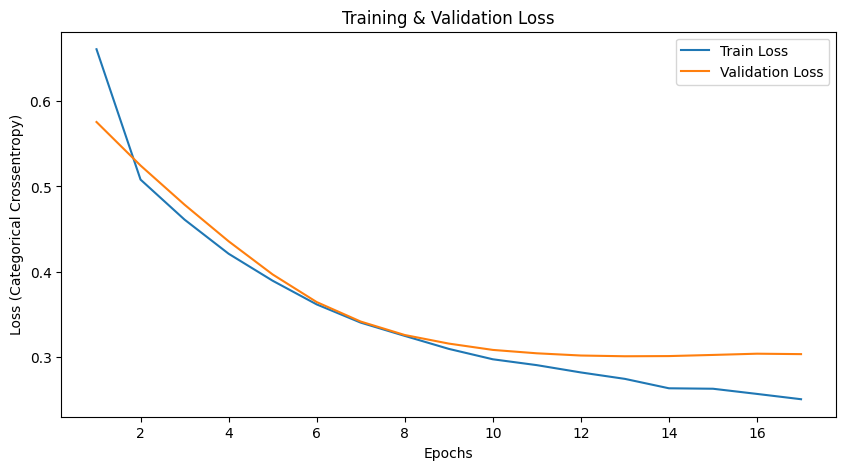

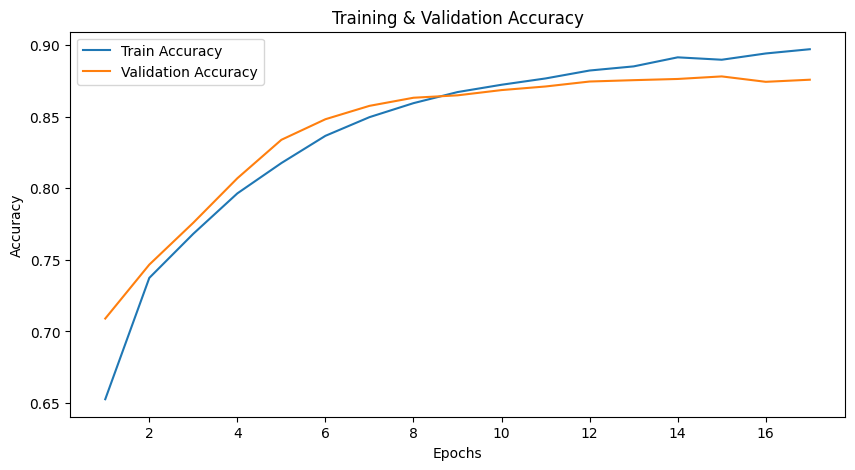

In [32]:
# Find the shortest training history (due to early stopping)
min_epochs = min(len(h["loss"]) for h in history_list)

# Trim all histories to the minimum epoch length
train_loss = np.mean([h["loss"][:min_epochs] for h in history_list], axis=0)
val_loss = np.mean([h["val_loss"][:min_epochs] for h in history_list], axis=0)

train_acc = np.mean([h["accuracy"][:min_epochs] for h in history_list], axis=0)
val_acc = np.mean([h["val_accuracy"][:min_epochs] for h in history_list], axis=0)

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, min_epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, min_epochs + 1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (Categorical Crossentropy)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, min_epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, min_epochs + 1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()

comment: The model is learning well, train/val curves are pretty similar. Loss curves smoothly going down while accuracy curves rising.

In [33]:
# Compute mean and standard deviation for validation metrics
val_accuracy_mean = np.mean([h["val_accuracy"][-1] for h in history_list])
val_accuracy_std = np.std([h["val_accuracy"][-1] for h in history_list])

val_precision_mean = np.mean([h["val_precision"][-1] for h in history_list]) if "val_precision" in history_list[0] else None
val_precision_std = np.std([h["val_precision"][-1] for h in history_list]) if "val_precision" in history_list[0] else None

val_recall_mean = np.mean([h["val_recall"][-1] for h in history_list]) if "val_recall" in history_list[0] else None
val_recall_std = np.std([h["val_recall"][-1] for h in history_list]) if "val_recall" in history_list[0] else None

val_f1_mean = np.mean([h["val_AUC"][-1] for h in history_list]) if "val_AUC" in history_list[0] else None
val_f1_std = np.std([h["val_AUC"][-1] for h in history_list]) if "val_AUC" in history_list[0] else None

# Print final results with standard deviations
print("\nFinal 3-Fold Cross-Validation Performance (from Training History):")
print(f"Validation Accuracy:  {val_accuracy_mean:.4f} ± {val_accuracy_std:.4f}")
if val_precision_mean is not None:
    print(f"Validation Precision: {val_precision_mean:.4f} ± {val_precision_std:.4f}")
if val_recall_mean is not None:
    print(f"Validation Recall:    {val_recall_mean:.4f} ± {val_recall_std:.4f}")
if val_f1_mean is not None:
    print(f"Validation AUC Score:  {val_f1_mean:.4f} ± {val_f1_std:.4f}")



Final 3-Fold Cross-Validation Performance (from Training History):
Validation Accuracy:  0.8742 ± 0.0069
Validation Precision: 0.8742 ± 0.0069
Validation Recall:    0.8742 ± 0.0069
Validation AUC Score:  0.9464 ± 0.0044


In [34]:
from sklearn.metrics import classification_report
# Convert to arrays for analysis
all_preds_per_epoch = np.array(all_preds_per_epoch)
all_true_per_epoch = np.array(all_true_per_epoch)

# Print class distribution per epoch
for epoch in range(len(all_preds_per_epoch)):
    print(f"\n* Epoch {epoch + 1} Predictions:")
    print(f"Unique Predictions: {np.unique(all_preds_per_epoch[epoch])}")
    print(f"Unique True Labels: {np.unique(all_true_per_epoch[epoch])}")

    # Show classification report for each epoch
    print("\nClassification Report:")
    print(classification_report(all_true_per_epoch[epoch], all_preds_per_epoch[epoch]))


* Epoch 1 Predictions:
Unique Predictions: [0 1]
Unique True Labels: [0 1]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       993
           1       0.89      0.84      0.86       912

    accuracy                           0.87      1905
   macro avg       0.87      0.87      0.87      1905
weighted avg       0.87      0.87      0.87      1905


* Epoch 2 Predictions:
Unique Predictions: [0 1]
Unique True Labels: [0 1]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1032
           1       0.90      0.84      0.87       873

    accuracy                           0.88      1905
   macro avg       0.88      0.88      0.88      1905
weighted avg       0.88      0.88      0.88      1905


* Epoch 3 Predictions:
Unique Predictions: [0 1]
Unique True Labels: [0 1]

Classification Report:
              precision    recall  f1-score   

comment: The model performed very well. The precesion, recall, accuracy and AUC are very balanced, the classification between electron and photon is well-performed by this model.This is potentially a result of a well-balanced dataset, proving potential success in the detector design.

### 2.3 NN Regression Model for Energy Reconstruction

In [35]:
# Ensure E_true is in the dataset
if "E" not in meta_dataframe.columns:
    raise ValueError("E_true is missing from the dataset. Ensure it is included in preprocessing.")

# Define target variable (original energy)
y = meta_dataframe["E"].values

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=Answer_to_all_questions)

# Define neural network model
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(256, activation="relu", input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1, activation="linear")  # Output layer for regression
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  loss="mse", 
                  metrics=["mae"])
    return model

In [36]:
# Initialize model
model = build_model(X_train.shape[1])

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=300, 
                    batch_size=64, 
                    callbacks=[early_stopping], 
                    verbose=1)

# Predict on test data
y_pred = model.predict(X_test)

Epoch 1/300


d:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 134650864.0000 - mae: 10084.1211 - val_loss: 127177368.0000 - val_mae: 9733.2090
Epoch 2/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134421936.0000 - mae: 10080.7783 - val_loss: 126827120.0000 - val_mae: 9725.8057
Epoch 3/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134095896.0000 - mae: 10073.7441 - val_loss: 126404136.0000 - val_mae: 9716.8682
Epoch 4/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133646040.0000 - mae: 10062.6885 - val_loss: 125881240.0000 - val_mae: 9704.1211
Epoch 5/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133063216.0000 - mae: 10047.4805 - val_loss: 125261312.0000 - val_mae: 9687.2275
Epoch 6/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132351048.0000 - mae: 10028.1152 - val_loss: 124517784.0000 - val_mae: 9667.2324
Epoch 7/300
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131518920.0000 - mae: 10004.6699 - val_loss: 123741816.0000 - val_mae: 9645.8066
Epoch 8/300
120/12


Model Performance:
Mean Squared Error (MSE): 5538368.5746
Root Mean Squared Error (RMSE): 2353.3739
R² Score: 0.8303


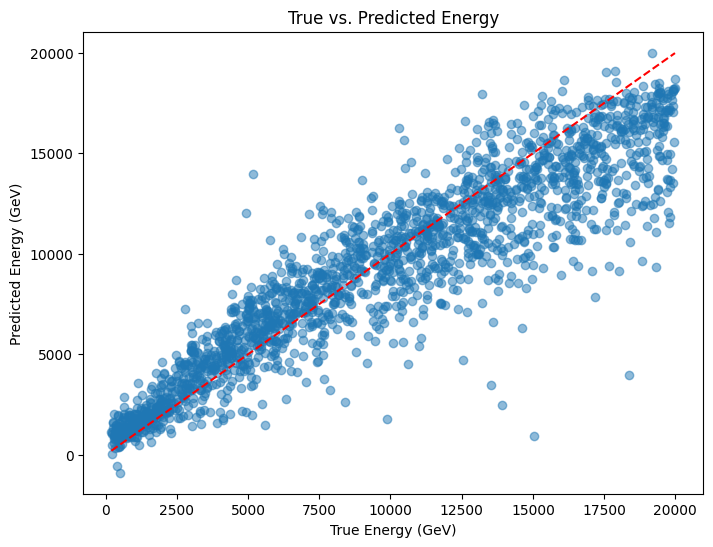

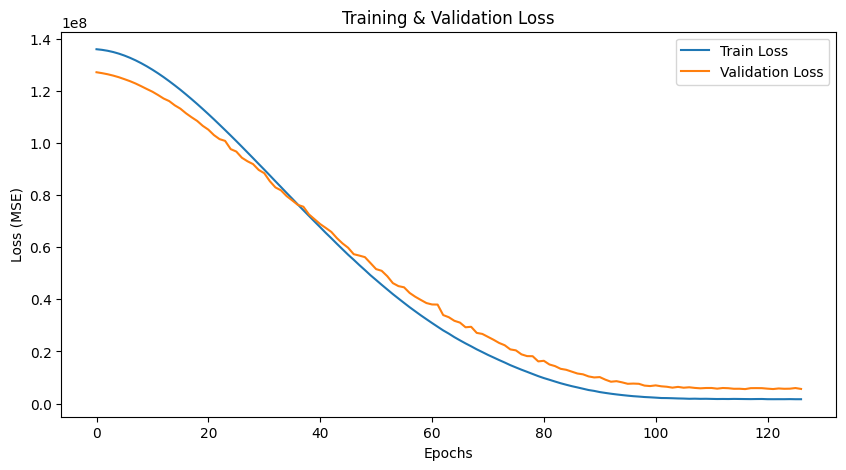

In [37]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot true vs predicted energy
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Energy (GeV)")
plt.ylabel("Predicted Energy (GeV)")
plt.title("True vs. Predicted Energy")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Reference line
plt.show()

# Plot training history
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

The loss curves are agreeing with each other.

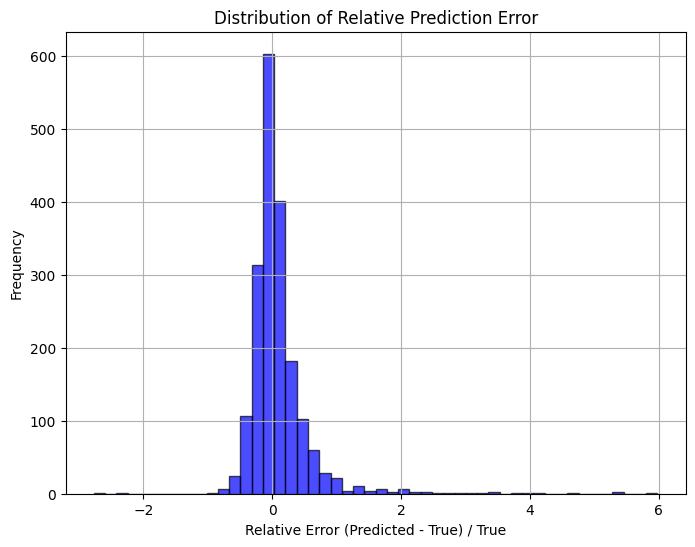


Error Distribution Statistics:
Mean Error: 0.0922
Standard Deviation of Error: 0.5116


In [38]:
# Compute error distribution (percentage error)
error_percentage = (y_pred.flatten() - y_test) / y_test

# Plot error distribution
plt.figure(figsize=(8,6))
plt.hist(error_percentage, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Relative Error (Predicted - True) / True")
plt.ylabel("Frequency")
plt.title("Distribution of Relative Prediction Error")
plt.grid(True)
plt.show()

# Print summary statistics of the error distribution
error_mean = np.mean(error_percentage)
error_std = np.std(error_percentage)

print(f"\nError Distribution Statistics:")
print(f"Mean Error: {error_mean:.4f}")
print(f"Standard Deviation of Error: {error_std:.4f}")

comment: the reconstruction of energy is relatively good as the energy resolution has a mean of around 0.1, but the std is around 0.5. Let's try make it even better, as the accuracy is good but not that precise. Also adjusted other hyperparameters like batchsize and dropout.

### 2.4 Improve the Energy Resolution

Changes: swish activation (often outperforms ReLU for smooth, continuous outputs like energy.), skip layer (can help with deeper models and gradient flow), loss functions huber (focus on outlyer handling).

In [62]:
def build_improved_model(input_shape):
    input_layer = keras.Input(shape=(input_shape,))
    
    # First dense block
    x = layers.Dense(512, activation="swish", kernel_regularizer=keras.regularizers.l2(0.0001))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    skip = x  # Residual connection before reducing

    # Second dense block
    x = layers.Dense(256, activation="swish", kernel_regularizer=keras.regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Third dense block
    x = layers.Dense(128, activation="swish", kernel_regularizer=keras.regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Fourth dense block
    x = layers.Dense(64, activation="swish")(x)
    x = layers.BatchNormalization()(x)

    # Match skip connection shape
    skip = layers.Dense(64)(skip)  # Project skip to 64 units

    # Residual connection
    x = layers.add([x, skip])

    # Output layer
    output = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs=input_layer, outputs=output)

    # Adam optimizer with learning rate decay
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)

    # Compile model with Huber loss, this handles outlyers as we have seen in teh previous model
    model.compile(optimizer=optimizer, loss="huber", metrics=["mae"])

    return model

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, verbose=1
)

# Initialize improved model
improved_model = build_improved_model(X_train.shape[1])

# Train improved model
history = improved_model.fit(X_train, y_train, 
                             validation_data=(X_test, y_test), 
                             epochs=600,  
                             batch_size=2048, 
                             callbacks=[early_stopping, lr_scheduler], 
                             verbose=1)
# Predict on test data
y_pred = improved_model.predict(X_test).flatten()

Epoch 1/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 10124.7266 - mae: 10125.1621 - val_loss: 9734.7744 - val_mae: 9735.2139 - learning_rate: 5.0000e-04
Epoch 2/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 10124.6367 - mae: 10125.0752 - val_loss: 9734.6582 - val_mae: 9735.1016 - learning_rate: 5.0000e-04
Epoch 3/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 10124.5088 - mae: 10124.9521 - val_loss: 9734.5312 - val_mae: 9734.9766 - learning_rate: 5.0000e-04
Epoch 4/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 10124.3770 - mae: 10124.8223 - val_loss: 9734.3945 - val_mae: 9734.8418 - learning_rate: 5.0000e-04
Epoch 5/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 10124.2090 - mae: 10124.6572 - val_loss: 9734.2344 - val_mae: 9734.6846 - learning_rate: 5.0000e-04
Epoch 6/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 10124.0469 - mae: 10124.4971 - val_loss: 9734.0459 - val_mae: 9734.4980 - learning_rate: 5.0000e-04
Epoch 7/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step -

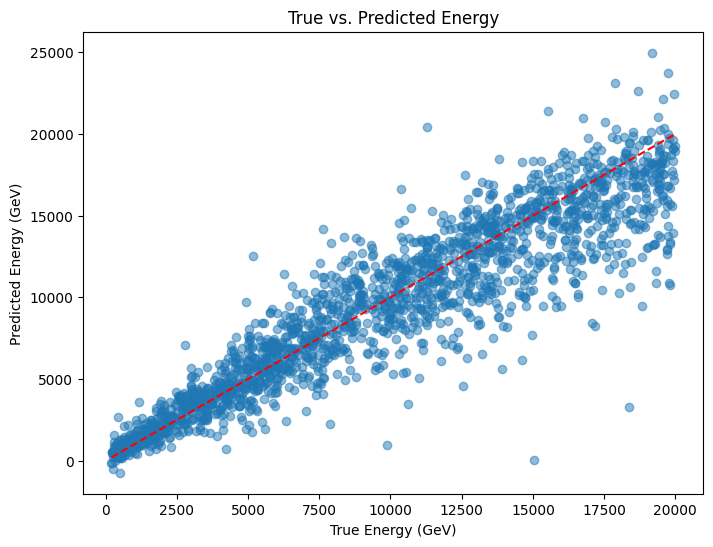

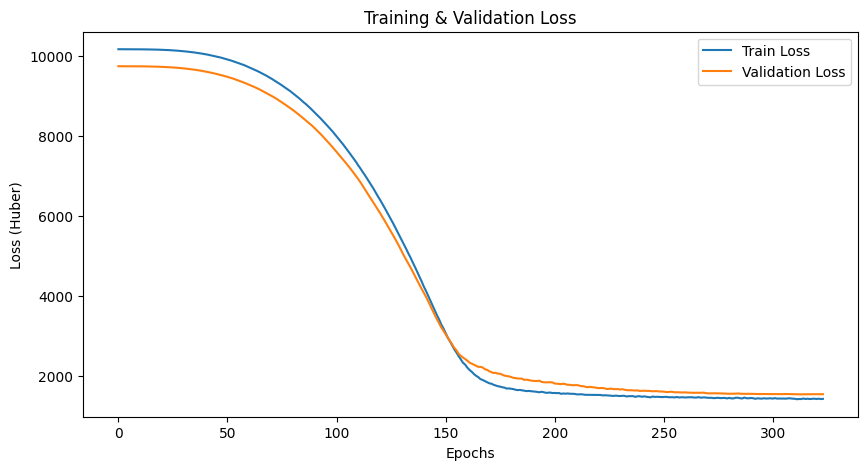

In [63]:
# Plot true vs predicted energy
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Energy (GeV)")
plt.ylabel("Predicted Energy (GeV)")
plt.title("True vs. Predicted Energy")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Reference line
plt.show()

# Plot training history
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (Huber)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

Still, good loss curves.

Improved Model Performance:
Mean Squared Error (MSE): 4875282.1976
Root Mean Squared Error (RMSE): 2208.0041
R² Score: 0.8506


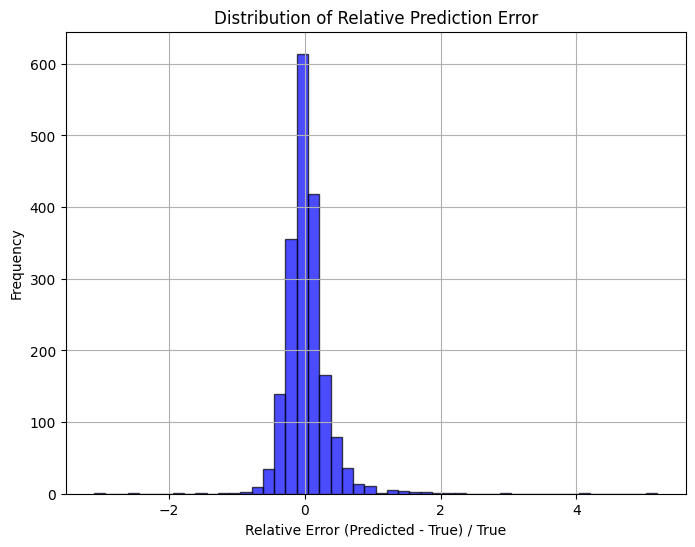


Error Distribution Statistics:
Mean Error: 0.0227
Standard Deviation of Error: 0.3582


In [64]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Improved Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
# Compute error distribution (percentage error)
error_percentage = (y_pred.flatten() - y_test) / y_test

# Plot error distribution
plt.figure(figsize=(8,6))
plt.hist(error_percentage, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Relative Error (Predicted - True) / True")
plt.ylabel("Frequency")
plt.title("Distribution of Relative Prediction Error")
plt.grid(True)
plt.show()

# Print summary statistics of the error distribution
error_mean = np.mean(error_percentage)
error_std = np.std(error_percentage)

print(f"\nError Distribution Statistics:")
print(f"Mean Error: {error_mean:.4f}")
print(f"Standard Deviation of Error: {error_std:.4f}")

This resolution is even better now, mean around 0.02 and error of 0.35. Almost improved by a factor of 2.

### Conclusion/ Discussion:

For the imporved detector design and much more complex data obtained, I used one new NN model for photon/electron distinguishing, and 2 NN models for energy reconstruction. The new detector design succeeded in capturing almost all events in 200MeV - 20GeV. The new model succeeded in distinguishing photons and electrons. Though the performance is surely worse than the basic model due to the very simplicity of the old data, the new model is working very well. For the two models of energy reconstruction, they all did a good job, with the second one much better, and they all beat the original simple method that has huge error and bias when energy gets larger.

There are also potential improvements. First, I am only taking a limited number of energetic daughter particles from each event to reduce the computing time and complexity of data, this can be better optimized by using a model that can carefully handle the untruncated data. For energy reconstruction, it is also better to use different models to learn different particles indivdually, this helps the model to focus on only one particle at a time to avoid potential confusing.